# Football Manager - the moneyball algorithm

The following script











<br><br>
## First: Preparation of the dataset
### Import the required modules
We use bs4 for parsing the html and pandas/numpy for dataframe operations. In the final step we will use matplotlib for visualisation.

In [1]:
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

<br><br>
### Open the html
Open the exported html-file from FM and decode it to get the german Umlaute right.

In [2]:
with open("Test.html", "rb") as fp:
    html = fp.read().decode("utf-8")
    soup = BeautifulSoup(html, features="lxml")

<br><br>
### Parsing the file
Parse the html-file with bs4 and find the important attributes as well as the column names.


In [3]:
body = soup.find_all("th")
attr = soup.find_all("td")

<br><br>
### Get columns and attributes
Fill the column-list and attributes-list with the matching attributes in the html-document.


In [4]:
columns = []
for i in body:
    columns.append(i.get_text())
attributes = []
for i in attr:
    attributes.append(i.get_text())
print("We got {} columns and {} rows with {} attributes. ".format(len(columns), round(len(attributes)/len(columns)),len(attributes)))

We got 13 columns and 67 rows with 871 attributes. 



<br><br>
## Let's start with the table work!
Create the dataframe and use a for-loop to fill the dataframe with the extracted attributes


In [5]:
tab = pd.DataFrame()
for i in range(1,len(attributes),len(columns)):
    liste1 = []
    dict = {}
    for j in range(1,len(columns)+1):
        liste1.append(attributes[(i-1)+(j-1)])
    for k in columns:
         dict[k] = liste1[columns.index(k)]
    tab = tab.append(dict,ignore_index=True)

Show the number of rows the table has.

In [6]:
tab.shape[0]

67

Show the first five rows of our generated table to get a first view on it.

In [7]:
tab.head()

,Rec,Inf,Name,Distance,Int/90,Tck W,Tck R,Aer A/90,Hdrs W/90,Pas A,Pas %,Gl Mst,Mins
0,- - 69 -,,Lorenzo van Kleef,198.4km,1.66,41,67%,3.65,1.34,976,81%,0,"2,492"
1,- - 62 -,,Anouar Kali,5.6km,1.18,2,100%,1.18,0.00,38,84%,0,76
2,- - 70 -,,Mcmoordy King Hüther,0.0km,-,10,91%,-,-,300,65%,0,"1,274"
3,- - 76 -,,Teun Bijleveld,31.6km,1.04,15,56%,2.08,0.21,175,75%,0,433
4,- - 89 -,Wnt,Jacky Donkor,156.6km,0.60,21,48%,2.73,0.51,614,64%,0,"2,107"


###### As we can see, our table has 67 rows and two unneccessary columns. Also we'd like to have the name column as index. 
<br><br>

In [8]:
tab = tab.set_index("Name")
tab = tab.drop(columns=["Rec","Inf"])

In [9]:
tab.head()

,Distance,Int/90,Tck W,Tck R,Aer A/90,Hdrs W/90,Pas A,Pas %,Gl Mst,Mins
Name,,,,,,,,,,
Lorenzo van Kleef,198.4km,1.66,41,67%,3.65,1.34,976,81%,0,"2,492"
Anouar Kali,5.6km,1.18,2,100%,1.18,0.00,38,84%,0,76
Mcmoordy King Hüther,0.0km,-,10,91%,-,-,300,65%,0,"1,274"
Teun Bijleveld,31.6km,1.04,15,56%,2.08,0.21,175,75%,0,433
Jacky Donkor,156.6km,0.60,21,48%,2.73,0.51,614,64%,0,"2,107"


##### Now our table looks a lot better but still has rows with empty values in it.
<br><br>

Define a regex that identifies all numeric values (plus an optional ","- or "."-separator) in our table.

In [10]:
import re
value = re.compile(r"\d+[,.]*\d*")

The following for-loop checks, if a row has empty-fields in it and additionally eliminates the thousand separator and units.
Finally we convert all values to floats to make them accessible for the arithmetic operations.

In [11]:
for i in tab.columns:

    # Delete a row when there is an empty field in any column
    for k in tab[i].iteritems():
        tab = tab.drop(tab[tab[i] == "-"].index)

    for j in range(len(tab[i])):
        a = value.search(tab[i].iloc[j])
        tab[i].iloc[j] = a.group()

        # Eliminate the thousand-separator to convert the string to float
        if "," in tab[i].iloc[j]:
            tab[i].iloc[j] = tab[i].iloc[j].replace(",","")
        else:
            pass

        # Convert all values to float if possible
        try:
            tab[i].iloc[j] = float(tab[i].iloc[j])
        except ValueError:
            pass

Get the number of rows again and get a view on the adjusted table.

In [12]:
tab.shape[0]

39

In [13]:
tab.head()

,Distance,Int/90,Tck W,Tck R,Aer A/90,Hdrs W/90,Pas A,Pas %,Gl Mst,Mins
Name,,,,,,,,,,
Lorenzo van Kleef,198.4,1.66,41.0,67.0,3.65,1.34,976.0,81.0,0.0,2492.0
Anouar Kali,5.6,1.18,2.0,100.0,1.18,0.0,38.0,84.0,0.0,76.0
Teun Bijleveld,31.6,1.04,15.0,56.0,2.08,0.21,175.0,75.0,0.0,433.0
Jacky Donkor,156.6,0.6,21.0,48.0,2.73,0.51,614.0,64.0,0.0,2107.0
Daryl van Mieghem,44.9,1.12,23.0,68.0,1.26,0.0,226.0,68.0,0.0,645.0



<br><br>
## Data manipulation

The data in the table is widely distributed.\
To make the columns comparable to each other, we use the mathematical concepts of standard scores and normalized scores.\
https://en.wikipedia.org/wiki/Standard_score 

In [14]:
stand = lambda a: (a - np.mean(a)) / np.std(a)                      # formula to create a standard score
norm = lambda a: (a - np.min(a)) / (np.max(a) - np.min(a))        # formula to create a normalized score

For visibility reasons we create another Dataframe, to store the newly created values.

In [15]:
rating_tab = pd.DataFrame()

<br><br>
### Creating new values

<br><br>
The majority of the stats are defined as "... per 90 minutes" so we create a <b>games</b> variable to use it in the following steps.

In [16]:
games = tab["Mins"]/90
round(games.astype(float),1).nlargest(5)

Name
Lorenzo van Kleef    27.7
Mohammed Tahiri      26.4
Henri Weigelt        25.6
Meris Skenderović    25.5
Dehninio Muringen    24.9
Name: Mins, dtype: float64

<br><br>
The <b>interceptions</b> are measured per 90 minutes, so we will multiply it with our games variable and afterwards use the normalized score.

In [17]:
rating_tab["interceptions"] = norm(tab["Int/90"]*games)
rating_tab["interceptions"].head()

Name
Lorenzo van Kleef    0.478647
Anouar Kali               0.0
Teun Bijleveld       0.042653
Jacky Donkor         0.138911
Daryl van Mieghem    0.074832
Name: interceptions, dtype: object

<br><br>
<b>Headers</b> are split into "aerial duels attempted" and "headers won per 90 minutes". To reward players, that made more overall attempts, we will multiply the attemps per 90 minutes with the total headers taken. Afterwards we will normalize this value.

In [18]:
tab["header_q"] = stand(tab["Hdrs W/90"]/tab["Aer A/90"])
tab["headers"] = norm(tab["Aer A/90"]*games)
rating_tab["headers"] = norm(tab["header_q"]*tab["headers"])
rating_tab["headers"].head()

Name
Lorenzo van Kleef    0.123642
Anouar Kali          0.234042
Teun Bijleveld       0.189297
Jacky Donkor              0.0
Daryl van Mieghem    0.182379
Name: headers, dtype: object

<br><br>
<b>Tackles</b> are measured by  "tackling rate" and "tackles won". So we will divide the won tackles with the tackling rate. Again we will multiply both values to reward active players. 

In [19]:
tab["tackles_q"] = stand(tab["Tck R"]/100)
tab["tackles"] = norm(tab["Tck W"]/(tab["Tck R"]/100))
rating_tab["tackles"] = norm(tab["tackles_q"]*tab["tackles"])
rating_tab["tackles"].head()

Name
Lorenzo van Kleef    0.365091
Anouar Kali          0.446829
Teun Bijleveld       0.269226
Jacky Donkor              0.0
Daryl van Mieghem    0.411202
Name: tackles, dtype: object

<br><br>
<b>Passes</b> are measured by "passing rate" and "attempted passes". We will multiply these values and normalize it.

In [20]:
tab["passes_q"] = stand(tab["Pas %"]/100)
tab["passes"] = norm(tab["Pas A"])
rating_tab["passes"] = norm(tab["passes_q"]*tab["passes"])
rating_tab["passes"].head()

Name
Lorenzo van Kleef    0.707259
Anouar Kali          0.420598
Teun Bijleveld       0.408586
Jacky Donkor              0.0
Daryl van Mieghem    0.323278
Name: passes, dtype: object

<br><br>
The <b>distance covered</b> value gets multiplied with our games value.

In [21]:
rating_tab["distance"] = norm(tab["Distance"]/games)
rating_tab["distance"].head()

Name
Lorenzo van Kleef    0.887252
Anouar Kali            0.8105
Teun Bijleveld       0.801376
Jacky Donkor         0.818776
Daryl van Mieghem    0.757804
Name: distance, dtype: object

<br><br>
<b>Mistakes leading to a goal</b> get normalized and multiplied with -1, so that players, who made no mistakes get the highest rating.

In [22]:
rating_tab["mistakes"] = norm(tab["Gl Mst"]*(-1))

<br><br>
### Creating and transforming the final rating table

<br><br>
The transforming of the given values is done and in the next step we will create a dictionary, which sets the weighting for each value.

In [23]:
weight_dict = {"interceptions": 4,
               "headers":4,
               "tackles": 4,
               "passes": 2,
               "distance": 2,
               "mistakes": 1}

*The weightings can be read as: Interceptions, Headers and Tackles are worth twice times as much as passes and distance covered and four times as much as mistakes leading to a goal.*

A formula for the creation of the final rating gets created and takes the weight_dict as an argument.

In [24]:
def create_rating(dict):
    c = 0
    d = 0
    for key, value in dict.items():                                 # iterate over the dictionary
        if value > 0:                                               # exlude values with a zero-weighting
            a = norm(rating_tab[key])*value                         # multiply the players value with its weighting
            b = value
            c += a                                                  # use c and d to add up all values
            d += b
        else:
            pass
    return c/d*100                                                  # get a number between 0 and 100
rating_tab["rating"] = create_rating(weight_dict)

Now we will sort the by descending values

In [25]:
rating_tab = rating_tab.sort_values(by="rating", ascending=False)

Get the columns of the table and remove the rating-value, because we will not display it in our final view.

In [26]:
columns = [i for i in rating_tab.columns]
columns.remove("rating")

Filter the table by the top 5 players by rating and define the players names as selection

In [27]:
FILTER = 5
rating_tab = rating_tab.astype(float).nlargest(FILTER,"rating")
selection = rating_tab.index
rating_tab

,interceptions,headers,tackles,passes,distance,mistakes,rating
Name,,,,,,,
Henri Weigelt,0.872281,1.000000,1.000000,0.749852,0.876960,1.0,92.604384
Tommy Grupe,0.851660,0.997824,0.649529,1.000000,0.690150,0.0,78.684412
Christian Dorda,1.000000,0.493513,0.391331,0.522968,0.924797,1.0,67.264142
Lukas Müller,0.851382,0.738198,0.624213,0.574137,0.674947,0.0,66.784348
Dehninio Muringen,0.871599,0.569316,0.422392,0.543883,0.879527,1.0,66.470881


*As you can see, the final table consists of 5 rows and our defined columns. To get a better overview, we will visualise the result.*

<br><br>
## Data visualisation

The final image will contain a barchart. The color saturation depends on the weighting of each value. Therefore we will create all values with the maximum value so that we can define each color right in the next step. Finally we will append the selected color into a list.


In [28]:
max_value = max(weight_dict.values())
for key, values in weight_dict.items():
    weight_dict[key] = values/max_value

In [29]:
selection_colors = []
color_dict = {}

for key, values in weight_dict.items():
    color_dict[key] = (0,0.49,0,values)
for i in columns:
    selection_colors.append(color_dict[i])

The final and greatest step.\
First we will define the size of the figure, which will contain all subplots.\
Then we define the edgecolor of the bars, the y-ticks and y-labels and the font sizes.\
The following for loop creates a subplot for each of the selected values (see FILTER variable above) with specific labeling and styling. \
In the end the plot is shown.

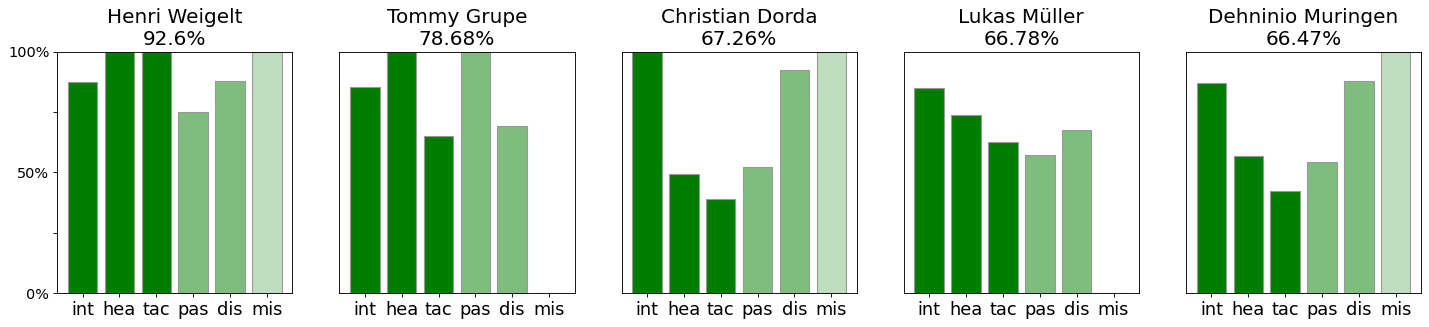

In [30]:
fig, ax = plt.subplots(1,len(selection))
fig.set_figwidth(22)
fig.set_figheight(4)
fig.set_dpi(80)

edgecolor = (0.6,0.6,0.6,1)
y_ticks = [0,0.25,0.5,0.75,1]
y_labels = ["0%","","50%","","100%"]

titlesize = 18
y_labelsize = 13
x_labelsize = 16



for i in range(0,len(selection)):
    plt.rc('axes', titlesize=15)  # fontsize of the axes title


    y = []
    x = []

    for j in columns:
        y.append(rating_tab[j][i])
        x.append(j[0:3])

    if i == 0:

        plt.tick_params(direction="out")
        a = plt.subplot(1,len(selection),i+1)
        plt.bar(x,y,color=selection_colors,edgecolor=edgecolor)
        plt.title(rating_tab.index[i]+"\n"+str(round(rating_tab["rating"][i],2))+"%",size=titlesize)
        plt.yticks(ticks=y_ticks,labels=y_labels,size=y_labelsize)
        plt.xticks(ticks=x,labels=x,size=x_labelsize)
        plt.ylim(0,1)


    else:
        plt.tick_params(direction="out")
        a = plt.subplot(1, len(selection), i + 1)
        plt.bar(x, y, color=selection_colors, edgecolor=edgecolor)
        plt.title(rating_tab.index[i] + "\n" + str(round(rating_tab["rating"][i], 2)) + "%",size=titlesize)
        plt.yticks([])
        plt.xticks(ticks=x, labels=x,size=x_labelsize)
        plt.ylim(0, 1)





plt.show()